# Speech Transcription on IPUs using Whisper Large - Inference

This notebook complements the previous [whisper inference notebook](whisper-example.ipynb) so you can run inference on IPUs with the larger configuration of whisper `whisper-large-v2` (1550M parameters).\
Compared to the whisper-large model, the large-v2 model is trained for 2.5x more epochs with added regularization for improved performance.

Whisper is a versatile speech recognition model that can transcribe speech as well as perform multi-lingual translation and recognition tasks.
It was trained on diverse datasets to give human-level speech recognition performance without the need for fine tuning. 

[🤗 Optimum Graphcore](https://github.com/huggingface/optimum-graphcore) is the interface between the [🤗 Transformers library](https://huggingface.co/docs/transformers/index) and [Graphcore IPUs](https://www.graphcore.ai/products/ipu).
It provides a set of tools enabling model parallelization and loading on IPUs, training and fine-tuning on all the tasks already supported by Transformers while being compatible with the Hugging Face Hub and every model available on it out of the box.

> **Hardware requirements:**  `whisper-large-v2` has 1550M parameters, it will need to use either an IPU-POD16 or a Bow Pod16 machine. Please contact Graphcore if you'd like assistance running model sizes that don't work in this simple example notebook.

[![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you.

To run the demo using other IPU hardware, you need to have the Poplar SDK enabled. Refer to the [Getting Started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to enable the Poplar SDK. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.

## Dependencies

IPU Whisper runs faster with the latest features available in SDK > 3.3 - check whether those features can be enabled. 

In [4]:
import re
import warnings

sdk_version = !popc --version
if sdk_version and (version := re.search(r'\d+\.\d+\.\d+', sdk_version[0]).group()) >= '3.3':
    print(f"SDK check passed.")
    enable_sdk_features=True
else:
    warnings.warn("SDK versions lower than 3.3 do not support all the functionality in this notebook so performance will be reduced. We recommend you relaunch the Paperspace Notebook with the Pytorch SDK 3.3 image. You can use https://hub.docker.com/r/graphcore/pytorch-early-access", 
                  category=Warning, stacklevel=2)
    enable_sdk_features=False

SDK check passed.


Install the dependencies the notebook needs.

In [5]:
# Install optimum from source 
!pip install git+https://github.com/huggingface/optimum-graphcore.git@d492f27434090a8e91c2ce5b84b5bd47490192f6 "tokenizers<0.13" "transformers==4.25.1" "soundfile" "librosa" "matplotlib"

Looking in indexes: https://pypi.org/simple, https://pypi.python.org/simple/
  Cloning https://github.com/huggingface/optimum-graphcore.git (to revision d492f27434090a8e91c2ce5b84b5bd47490192f6) to /tmp/pip-req-build-dio31zd4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/optimum-graphcore.git /tmp/pip-req-build-dio31zd4
  Running command git rev-parse -q --verify 'sha^d492f27434090a8e91c2ce5b84b5bd47490192f6'
  Running command git fetch -q https://github.com/huggingface/optimum-graphcore.git d492f27434090a8e91c2ce5b84b5bd47490192f6
  Resolved https://github.com/huggingface/optimum-graphcore.git to commit d492f27434090a8e91c2ce5b84b5bd47490192f6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of optimum-graphcore to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot inst

## Running Whisper on the IPU

We start by importing the required modules, some of which are needed to configure the IPU.


In [6]:
# Generic imports
from datasets import load_dataset
import matplotlib.pyplot as plt
import librosa
import IPython
import random

# IPU-specific imports
from optimum.graphcore import IPUConfig
from optimum.graphcore.modeling_utils import to_pipelined
from optimum.graphcore.models.whisper import WhisperProcessorTorch

# HF-related imports
from transformers import WhisperForConditionalGeneration

We download `whisper-large-v2` which we will run using eight IPUs.
The [Whisper architecture](https://openai.com/research/whisper) is an encoder-decoder Transformer, with the audio split into 30-second chunks.
The `IPUConfig` object helps to configure the model to be pipelined across the IPUs.
We will use 4 IPUs to place the encoder and 4 IPUs for the decoder.
The number of transformer layers per IPUs is adjusted by using `layers_per_ipu`.

In [8]:
# Adapt whisper-large to run on the IPU
ipu_config = IPUConfig(
        executable_cache_dir="./whisper_exe_cache",
        ipus_per_replica=8,
        layers_per_ipu=[8, 8, 8, 8, 6, 9, 9, 8],
    )

In [10]:
model_spec = "openai/whisper-large-v2"

# Instantiate processor and model
processor = WhisperProcessorTorch.from_pretrained(model_spec)
model = WhisperForConditionalGeneration.from_pretrained(model_spec)
pipelined_model = to_pipelined(model, ipu_config)
pipelined_model = pipelined_model.parallelize(
    for_generation=True, 
    use_cache=True, 
    batch_size=1, 
    max_length=250,
    on_device_generation_steps=16, 
    use_encoder_output_buffer=enable_sdk_features).half()

Now we can load the dataset and process an example audio file.
If precompiled models are not available, then the first run of the model triggers two graph compilations.
This means that our first test transcription could take a minute or two to run, but subsequent runs will be much faster.

In [11]:
# load the dataset and read an example sound file
ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
test_sample = ds[2]
sample_rate = test_sample['audio']['sampling_rate']

def transcribe(data, rate):
    input_features = processor(data, return_tensors="pt", sampling_rate=rate).input_features.half()

    # This triggers a compilation, unless a precompiled model is available.
    sample_output = pipelined_model.generate(
        input_features,
        use_cache=True,
        do_sample=False,
        max_length=448, 
        min_length=3)
    transcription = processor.batch_decode(sample_output, skip_special_tokens=True)[0]
    return transcription

test_transcription = transcribe(test_sample["audio"]["array"], sample_rate)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_dummy downloaded and prepared to /home/alexandrec/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:23<00:00]
2023-06-26T10:03:36.610644Z popart:devicex 439314.439314 W: Specified directory not found. Creating "./whisper_exe_cache" directory 
Graph compilation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:44<00:00]


In the next cell, we compare the expected text from the dataset with the transcribed result from the model.

You can listen to the audio and compare the model result yourself using the controls below.

Expected: HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND

Transcribed:  He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind.


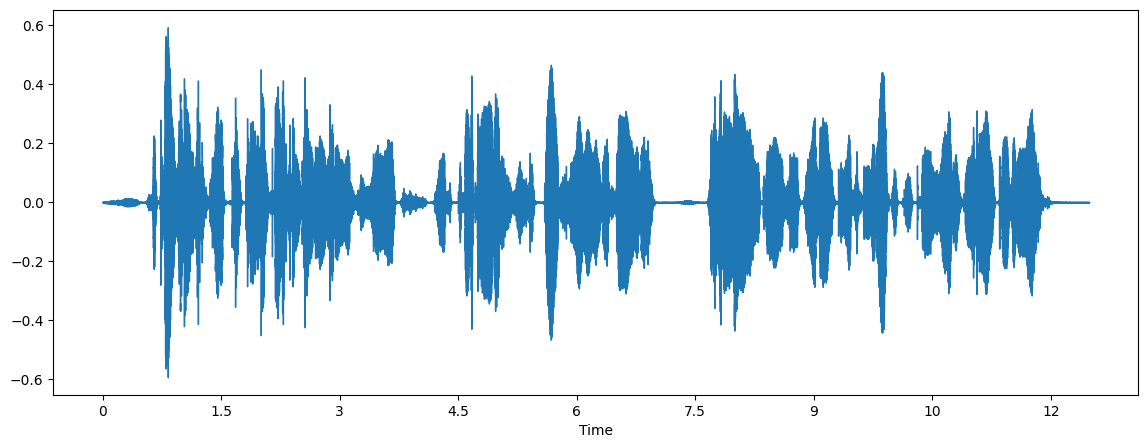

In [12]:
print(f"Expected: {test_sample['text']}\n")
print(f"Transcribed: {test_transcription}")

plt.figure(figsize=(14, 5))
librosa.display.waveshow(test_sample["audio"]["array"], sr=sample_rate)
IPython.display.Audio(test_sample["audio"]["array"], rate=sample_rate)

The model only needs to be compiled once. Subsequent inferences will be much faster.
In the cell below, we repeat the exercise but with a random example from the dataset.

You might like to re-run this next cell multiple times to get different comparisons.

Example #11

Expected: IN FACT HE IS QUITE SEVERE ON MISTER RUSKIN FOR NOT RECOGNISING THAT A PICTURE SHOULD DENOTE THE FRAILTY OF MAN AND REMARKS WITH PLEASING COURTESY AND FELICITOUS GRACE THAT MANY PHASES OF FEELING

Transcribed:  In fact, he is quite severe on Mr. Ruskin for not recognizing that a picture should denote the frailty of man, and remarks with pleasing courtesy and felicitous grace that many phases of feeling


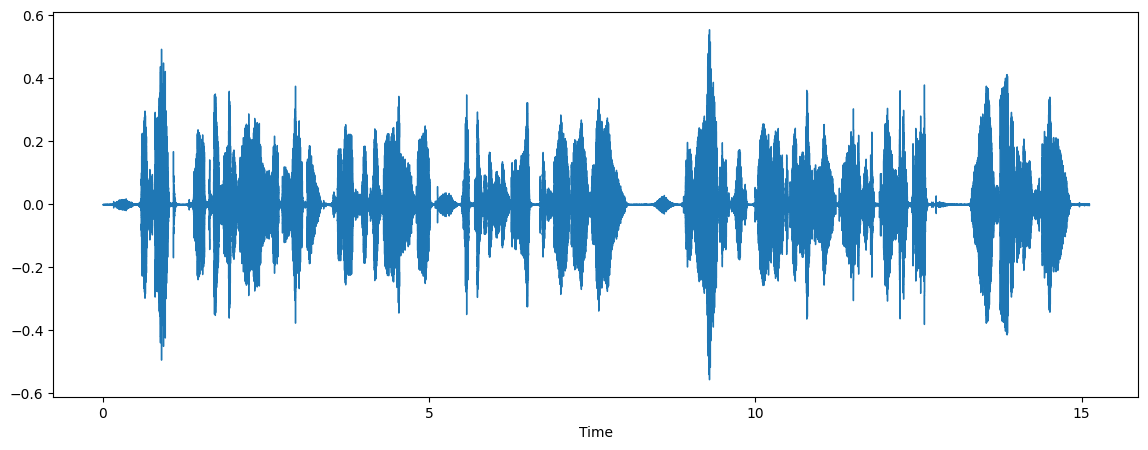

In [24]:
idx = random.randint(0, ds.num_rows - 1)
data = ds[idx]["audio"]["array"]

print(f"Example #{idx}\n")
print(f"Expected: {ds[idx]['text']}\n")
print(f"Transcribed: {transcribe(data, sample_rate)}")

plt.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sample_rate)
IPython.display.Audio(data, rate=sample_rate, autoplay=True)

Finally, we detach the process from the IPUs when we are done to make the IPUs available to other users.

In [25]:
pipelined_model.detachFromDevice()